# tutorial2.ipynb

Synaptic plasticity and spatially arranged connections in draculab.

**FOREWORD**  
Plasticity rules for firing rate neurons usually assume that you have a set of input vectors $\{ {\bf x}^{(1)}, {\bf x}^{(2)}, \dots, {\bf x}^{(n)} \}$, 
where ${\bf x}^{(j)} = (x_1^{(j)}, \dots, x_k^{(j)})^T$.   
These input vectors are applied to the network in discrete presentations, each causing a change $\Delta \boldsymbol{\omega}^{(j)}$ on the vector of 
synaptic weights $\boldsymbol{\omega} = (\omega_1, \omega_2, \dots, \omega_k)^T$.

For example, the  [Oja learning rule](http://www.scholarpedia.org/article/Oja_learning_rule) states that presenting ${\bf x} = (x_1, \dots, x_k)$ will 
produce a change $\Delta \omega_i$ in $\omega_i$, characterized by the equation:  
$ \Delta \omega_i = \alpha \left(x_i y - y^2 \omega_i \right), \ \ i=1, \dots, k. $,  
where $\alpha$ is a learning rate, and $y$ is the response of the neuron to the input ${\bf x}$.

When we work with networks that operate in continuous time we no longer have discrete input vectors, and the learning rule must be adapted.
The most straightforward way to do this is by assuming that the learning rule describes the derivative of $\omega_i$, so we end up with something like:   
$ \frac{d \omega_i}{dt} = \alpha \left(x_i(t) y(t) - y^2(t) \omega_i \right), \ \ i=1, \dots, k. $,  
where $x_i(t), y(t)$ are functions of time. We use a function ${\bf x}(t)$ that gradually transitions through the patterns 
$\{ {\bf x}^{(1)}, {\bf x}^{(2)}, \dots, {\bf x}^{(n)} \}$ in continuous time. In the first part of the tutorial we create a unit with plastic connections and observe whether it behaves like its discrete counterpart. 

The next step would be to program a network whose units have plastic synapses. This implies specifying how the units are connected to each other, 
which can be a complicated endeavour. Before attempting this, the second part of the tutorial presents draculab's `topology` module, which allows to create spatially structured connections. In the next tutorial a network with plastic synapses is presented.

The networks in this tutorial are is an open-loop systems (because the outputs of the network don't affect its inputs). Tutorial 4 provides a simple closed-loop simulation.

## Part 1
Creating a unit with adaptive connections.

The  [Oja learning rule](http://www.scholarpedia.org/article/Oja_learning_rule) is supposed to extract the first principal component of the input correlation
matrix. If we create a matrix with our input vectors, say $M = [ {\bf x}^{(1)} \ {\bf x}^{(2)} \dots \ {\bf x}^{(n)} ]$, the input correlation matrix is
$C = M M^T$. Notice that $C_{i,j}$ shows how the $x_i$ component of the input vectors correlates with the $x_j$ component. When using linear units, it can be shown that using the Oja learning rule can (approximately) produce a weight vector $\boldsymbol{\omega}$ such that 
$C \boldsymbol{\omega} = \lambda \boldsymbol{\omega}$, where $\lambda$ (the principal eigenvalue) is the scalar $\boldsymbol{\omega}^T C \boldsymbol{\omega}$.

This tutorial is not concerned with the meaning of all this. We want to see if a continous version of the rule can still produce this result in a toy problem.

The programming part is similar to the first tutorial, but we now have to produce a slighltly more complex input, and change the synapse specifications.

In [1]:
# Importing...
%cd .. 
from draculab import *
import matplotlib.pyplot as plt
import time
from mpl_toolkits.axes_grid1 import ImageGrid 
# mpl_toolkits should be included with matplotlib. If it is not present (as happened with some 
# Ubuntu releases) please reinstall matplolib

/home/z/projects/draculab


In [8]:
# We create the network as before, using a single linear unit
net_params = {
    'min_delay' : 0.005, # minimum delay in all the network's connections (in seconds)
    'min_buff_size' : 10 } # minimum buffer size. How many values are stored per simulation step. 
net = network(net_params)

n_lins = 1 # how many linear units to create
lin_params = {
    'type' : unit_types.linear,
    'init_val' : 0.5, # initial value
    'tau_fast' : 0.05, # see explanation below
    'coordinates' : np.array([0., 0.]), # not required. Just a preview of what's to come
    'tau' : 0.02 } # time constant for the dynamics of all linear units
lin_ids = net.create(n_lins, lin_params)

n_sources = 9 # how many input units to create
input_params = {
    'type' : unit_types.source,
    'init_val' : 0.5,
    'tau_fast' : 0.05, # see explanation below
    'function' : lambda t: None } 
inp_ids = net.create(n_sources, input_params)

conn_spec = {
    'rule' : 'all_to_all', 
    'delay' : .1 } 
syn_pars = {
    'type' : synapse_types.oja, # Oja synapses. The oja_synapse class in synapses.py
    'init_w' : {'distribution':'uniform', 'low':.1, 'high':.5}, 
    'lrate' : 0.2 } # learning rate
net.connect(inp_ids, lin_ids, conn_spec, syn_pars)


Signals in continuous time can experience fast fluctuations. In draculab, learning rules that depend on presynaptic and postsynaptic activities (such
as the Oja rule) depend on continous signals. To reduce the effect of fluctuations and enhance stability, instead of directly using the presynaptic
and postsynaptic activities, draculab uses low-pass filtered versions of them. A first-order low-pass filtered basically provides an average of the
recent values for the filtered signal. The parameter `tau_fast` is the time constant of the first-order filter used.

When a synapse that uses low-pass filters (such as `oja`) is connected, it automatically requests the postsynaptic and/or postsynaptic units(s) to keep
low-pass filtered versions of their activity (the LPF'd activity). Quantities other than LPF'd activities can be requested by the synapse to the unit,
such as the sum of all weights, or the average of the inputs. In this way the same computation doesn't have to repeat in all synapse objects,
but is instead done once in the unit object.

In [9]:
# Now we create the input functions.

### We are going to present 4 input patterns that randomly switch over time.
### Imagine the 9 inputs arranged in a grid, like a tic-tac-toe board, numbered
### from left to right and from top to bottom:
### 1 2 3
### 4 5 6
### 7 8 9
### You'll have input patterns
### 0 X 0   0 0 0   X 0 X   0 X 0
### 0 X 0   X X X   0 0 0   X 0 X
### 0 X 0   0 0 0   X 0 X   0 X 0
### Each pattern will appear for t_pat time units, and then the input will adopt
### a different pattern by changing its values linearly through time for t_trans time units.
### Thus, the input is always a normalized linear combination of one or two of the patterns.
### Pattern pat1 is presented alone for t_pat time units, and then there is a transition period
### during which pat1 becomes pat2 by presenting at time t an input 
### c*(t_pat+t_trans - t)*pat1 + c*(t - tpat)*pat2
### where c = 1/t_trans, and t_trans is the duration of the transition period. 
### At time t_pat+t_trans, pat2 is presented by itself for t_pat time units.
### 
# here are the patterns as arrays
patterns = [np.zeros(n_sources) for i in range(4)]
patterns[0] = np.array([0., 1., 0., 0., 1., 0., 0., 1., 0.])/3.
patterns[1] = np.array([0., 0., 0., 1., 1., 1., 0., 0., 0.])/3.
patterns[2] = np.array([1., 0., 1., 0., 0., 0., 1., 0., 1.])/4.
patterns[3] = np.array([0., 1., 0., 1., 0., 1., 0., 1., 0.])/4.

def make_pat_fun(idx):
    # This creates a constant function with value: patterns[cur_pat][idx],
    # used to initialize the source units as in tutorial 1
    fun = lambda t : patterns[cur_pat][idx]
    return fun

def make_trans_fun(idx, last_t):
    # Creates a function for the pattern transition
    fun = lambda t : c * ( (t_trans - (t-last_t))*patterns[cur_pat][idx] +
                           (t-last_t)*patterns[next_pat][idx] )
    return fun

t_pat = 2. # as described above
t_trans = .3 # as described above
c = 1/t_trans # auxiliary variable
cur_pat = np.random.choice(4)  # pattern currently presented
next_pat = np.random.choice(4) # next pattern to be presented
last_t = 0. # time when the last pattern ended
#weights = np.array(net.units[lin_ids[0]].get_weights(net.sim_time)) # initial weights of the linear unit


In [10]:
# We run the simulation.

# In order for the unit to learn properly, the input patterns need to be presented
# many times. Instead of creating input functions capable of presenting all the
# patterns, we simulate one pattern presentation at a time. After each presentation
# we change the input function used by the source units.

n_pres = 100 # number of times some pattern will be presented
start_time = time.time() # used to time the simulation
times = np.array([]) # used to store the times array from all simulations
activs = np.tile([], (len(net.units),1)) # used to store the activities array from all simulations
run_activs = [] # auxiliary list used to concatenate activities

for pres in range(n_pres):
# For each cycle you'll set the input functions and simulate, once with a single pattern,
# once with a mix of patterns, as described above   
    # first, we present a single pattern
    for u in range(n_sources):
        net.units[inp_ids[u]].set_function( make_pat_fun(u) )
        
    sim_dat = net.run(t_pat)  # simulating
    last_t = net.sim_time # simulation time after last pattern presentation
    times = np.append(times, sim_dat[0])
    run_activs.append(sim_dat[1])
    
    # now one pattern turns into the next
    for u in range(n_sources):
        net.units[inp_ids[u]].set_function(make_trans_fun(u, last_t))
    
    sim_dat = net.run(t_trans) # simulating
    times = np.append(times, sim_dat[0])
    run_activs.append(sim_dat[1])
    
    # choose the pattern you'll present next
    cur_pat = next_pat
    next_pat = np.random.choice(4)
    
    if pres%10 == 0:
        print('Finished presentation ' + str(pres))
        
activs = np.append(activs, np.concatenate(run_activs, axis=1), axis=1)  
print('Execution time: %s seconds' % (time.time() - start_time)) 

Finished presentation 0
Finished presentation 10
Finished presentation 20
Finished presentation 30
Finished presentation 40
Finished presentation 50
Finished presentation 60
Finished presentation 70
Finished presentation 80
Finished presentation 90
Execution time: 8.843799591064453 seconds


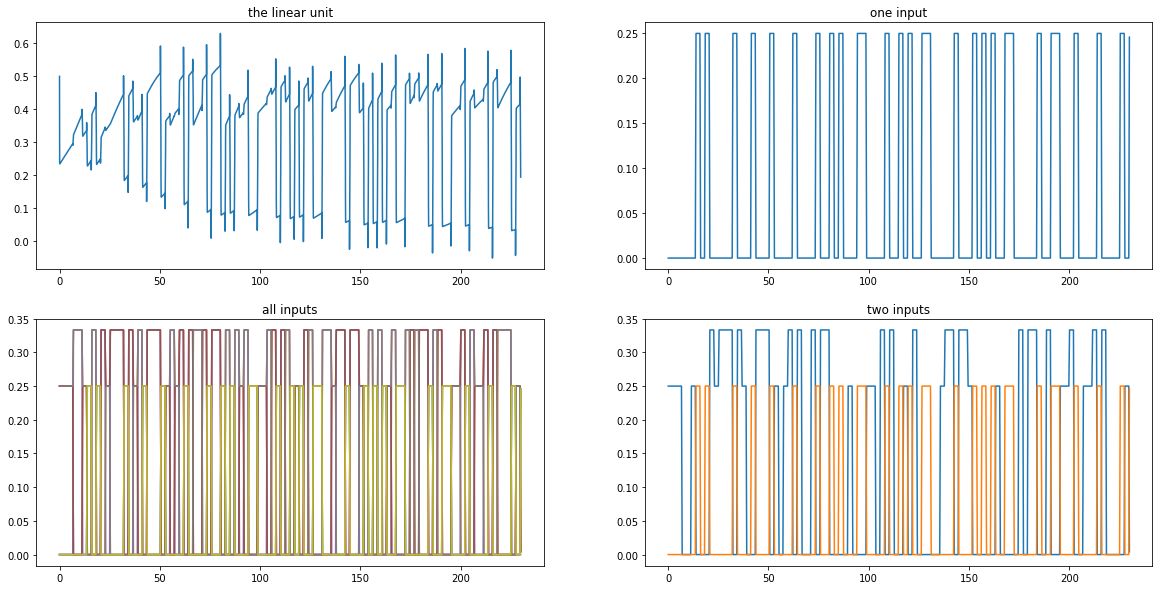

In [11]:
# Plot the activities of the units using Matplotlib

fig1 = plt.figure(figsize=(20,10))
# Plot the activity of the linear unit
plt.subplot(221)
plt.plot(times, activs[lin_ids[0]])
plt.title('the linear unit')
# Plot the activity of one input unit
plt.subplot(222)
plt.plot(times, activs[inp_ids[2]])
plt.title('one input')
# Plot the activity of all inputs
inp_acts = [ activs[u] for u in inp_ids ]
plt.subplot(223)
plt.plot(times, np.transpose(inp_acts))
plt.title('all inputs')
# Plot the activity of some inputs
plt.subplot(224)
inp_acts = [ activs[inp_ids[3]], activs[inp_ids[6]] ]
plt.plot(times, np.transpose(inp_acts))
plt.title('two inputs')
plt.show()

angle between vectors: 0.102636 radians
['0.00', '0.43', '0.00', '0.43', '0.50', '0.43', '0.00', '0.43', '0.00']
['0.04', '0.45', '0.04', '0.39', '0.54', '0.39', '0.04', '0.45', '0.04']


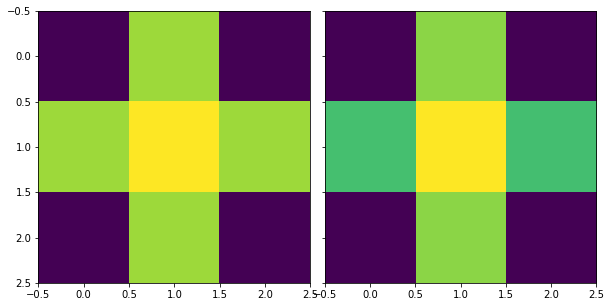

In [12]:
# Now that the simulation is done, we want to compare the weight vector of the 
# linear unit with the leading eigenvector of the input correlation matrix.
# If these two vectors are similar, then the Oja rule succeeded in extracting
# the eigenvector in continuous time.

# Obtaining the weight vector of the linear unit is straighforward
weights = np.array(net.units[lin_ids[0]].get_weights(net.sim_time))

# Next we get the eigenvectors of the correlation matrix
pat_arr = np.array(patterns) # a numpy array composed of the input vectors
corr = np.matmul(pat_arr.transpose(), pat_arr) # input correlation matrix
eigs = np.linalg.eig(corr) # extracting eigenvalues and eigenvectors
evals = eigs[0] # these are the eigenvalues
evecs = [eigs[1][:,i] for i in range(9)] # these are the eigenvectors

# extracting the leading eigenvector (the eigenvector with the largest eigenvalue)
max_index, max_value = max(enumerate(evals), key=lambda p:p[1])
#print('leading eigenvalue: ' + str(max_value) + ', index: ' + str(max_index))
max_evector = evecs[max_index]  # this is the leading eigenvector

# In order to compare the two vectors, we normalize them and 'flatten' them
weights /= np.linalg.norm(weights) # normalize the weight vector
max_evector /= np.linalg.norm(max_evector) # normalize the eigenvector
weights1D = weights.reshape(9)
max_ev1D = -max_evector.reshape(9) 
# also changed the sign, which doesn't change the eigenvector's identity

# we obtain the angle between the two vectors
angle = np.arccos(np.dot(weights1D, max_ev1D))
print("angle between vectors: %f radians" % (angle))

# plotting leading eigenvector VS weight vector in 3x3 format
fig2 = plt.figure(figsize=(12,5))
sp_ev_grid = ImageGrid(fig2, 111, nrows_ncols=(1,2), axes_pad=0.2)
for idx,vec in enumerate([-max_evector, weights]):
    vec.shape = 3,3
    sp_ev_grid[idx].imshow(vec)
    # also printing the vectors in a readable format
    print(["%.2f" % float(v[0]) for v in vec.reshape(9,1)])
    
plt.show()

## Part 2
draculab's `topology` module.

Part 1 had a single linear unit, and there was little point in having continous-time dynamics. We move into a network that has a population of interconnected sigmoidal units. Rather than following the basic connectionist paradigm leading to multilayer perceptrons, we use a more biologically-inspired architecture.

Biological neural networks are sparsely connected, meaning that each neuron only sends projections to a relatively small fraction of the population. The projections usually form feedback loops, unlike the feedforward neural architectures that are ubiquitous in machine learning. Biologically plausible connectivity patterns can be better described using probabilities of connection that depend on the spatial relation between the neurons to be connected. To create these type of connections draculab has a `topology` module, largely inspired in the [topology module](http://www.nest-simulator.org/part-4-topologically-structured-networks/) of the [NEST](http://www.nest-simulator.org/) neural simulator.

As a stepping stone to create a network with spatially structured adaptive connections, we learn about draculab's `topology` module.

In [1]:
# Importing... PLEASE RESET THE KERNEL BEFORE CONTINUING WITH PART 2
%cd .. 
from draculab import *
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


The topology module contains two important methods:
`topology.create_group`, and `topology.topo_connect`.

The idea behind the topology module is that every unit has a `coordinates` attribute, which is a numpy 1D array with 2 or 3 elements.
Based on their relative positions we can adjust the proabability that any two units are connected, as well as the synaptic weights, and connection delays.

The coordinates of the units can be set manually in their parameters dictionary, but this is usually cumbersome. The `create_group` method is here to ease the burden. 
`create_group` is basically a front end for `network.create_units`, but it receives an extra parameter dictionary to specify how to assign
the coordinates to the units being created. At this point `create_group` only creates 2D grids of units.

In [13]:
# more information
help(topology.create_group)

Help on function create_group in module topology:

create_group(self, net, geometry, params)
    Create a group of units with a particular spatial arrangement.
    
    This method uses the specifications given in the 'geometry' argument to decide
    how many units to create, and assign them coordinates. It then calls network.create_units.
    This is not like NEST's topology.CreateLayer method. In here we are just creating
    units with particular coordinates, no other objects are involved.
    
    The units of measurement (e.g. millimeters) are unspecified; the implementer is
    responsible for their consistency.
    
    The current implementation can only do one thing: create flat 2D layers with a given
    number of rows and columns.
    
    Args:
        net : The network where the units will be created.
    
        geometry : A dictionary specifying the spatial location of the units.
            REQUIRED ENTRIES
            'shape': a string with the geometrical shape of t

Once we have populations of units with properly assigned coordinates, we can use `topo_connect` to connect them.
The options in `topo_connect` are reminsicent of those in PyNEST's [topology module](http://www.nest-simulator.org/part-4-topologically-structured-networks/), but there are important differences that need to be explained.

The docstring of `topo_connect` is long, and not obvious at first, so let's explain some of its contents.

In [13]:
help(topology.topo_connect)

Help on function topo_connect in module topology:

topo_connect(self, net, from_list, to_list, conn_spec, syn_spec)
    Connect two groups of units based on their spatial locations.
    
    This method is a version of network.connect() with two modifications:
    1) All units involved must have a valid 'coordinates' attribute. One way to set the 
       coordinates is by using the create_group() method instead of network.create().
    2) The conn_spec dictionary uses a set of entries different to network.connect(). These 
       entries specify the spatial connection profile using almost the same options as PyNEST's 
       topology module.
    
    topo_connect() works by first specifing which units to connect, with which weights,
    and with which delays. Using this it calls the network.connect() method. The received syn_spec
    dictionary is used when calling network.connect(), but the init_w values may be modified. 
    
    Args:
        net : The network where the units will b

As can be seen, there are 5 arguments to `topo_connect`. These are basically the same as those used with
`network.connect`, with the addition of `net`, which is the network instance where the connections will be made.

The difference with `network.connect` is in the contents of the `conn_spec` dictionary, since we will now use a different
way to specify which units should be connected. The way it works depends on whether we set the `connection_type` parameter to
`convergent` or `divergent`. Let's explain the case of convergent connections.

Let's say unit `b` is in `to_list`, and you're considering whether it shoud receive a projection from unit `a` in `from_list`. First we see if `a` is inside `b`'s mask. The mask is a spatial region that depends on `b`'s coordinates; only units inside the mask are eligible to send connections to `b`. If `a` is inside `b`'s mask, then it has a probability of connecting to `b` given by the kernel function. The kernel function expresses the probability of `a` connecting to `b` as a function of their distance. Thus, we generate the connection between `a` and `b` with this probability.

In the case of divergent connections, the difference is that the mask is applied to the units of the `to_list`. So to decide if `a` connects to `b`, we first check whether `b` is inside of `a`'s mask.

The next example illustrates these and other settings of the `conn_spec` dictionary.

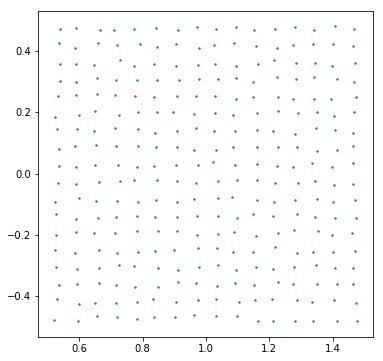

In [2]:
""" In this cell we use the create_group method with the 'sheet' shape and 'grid' arrangement """
topo = topology()  # creating an instance of the topology class

# Create network
net_params = {'min_delay' : 0.2, 
              'min_buff_size' : 4 } # parameter dictionary for the network
net = network(net_params)

# Create group of units
unit_pars = { 
    'init_val' : 0.5, 
    'function' : lambda x: None, 
    'type' : unit_types.source } 
geom = { 'shape':'sheet', 
         'extent':[1.,1.], 
         'center':[1.,0.], 
         'arrangement':'grid', 
         'rows':18, 
         'columns':16, 
         'jitter' : 0.01 } 
ids = topo.create_group(net, geom, unit_pars)  # creating the units

# Plot the unit locations
xvals = [ u.coordinates[0] for u in net.units ]
yvals = [ u.coordinates[1] for u in net.units ]
figg = plt.figure(figsize=(6,6))
plt.scatter(xvals, yvals, s=2.)
plt.show()

In [3]:
""" This cell uses the topo_connect method with the network in the previous cell. """

# create the spec dictionaries
conn_spec = {'connection_type' : 'divergent',
             'mask' : {"annular" : {"inner_radius": .2, 'outer_radius':.5}},
             'kernel' : .8, 
             #'kernel' : {'gaussian':{'p_center':.2, 'sigma':3.}},
             #'kernel' : {'linear' : {'c' : 1., 'a' : .3}},
             'delays' : {'linear' : {'c':0.1, 'a':0.1}},
             'weights' : {'linear' : {'c':5., 'a':1.}},
             'edge_wrap' : True,
             'boundary' : {'center' : geom['center'], 'extent' : geom['extent']},
            }
syn_spec = {'type' : synapse_types.static, 'init_w' : 0.2 }

# Connect. This might take some time.
topo.topo_connect(net, ids, ids, conn_spec, syn_spec)

The draculab core programs do not offer a method to visualize connections. This is not hard using
Matplolib. Below is one simple script to check that the connections look as they should. 

A faster, but slightly more complex version of the code below is at the bottom of this notebook. This faster version  is a
reduced adaptation of the `conn_anim` function of the `ei_net` and `ei_network` classes, to be described later. 
You can suubstitute the cell below for the cell at the bottom.

<IPython.core.display.Javascript object>


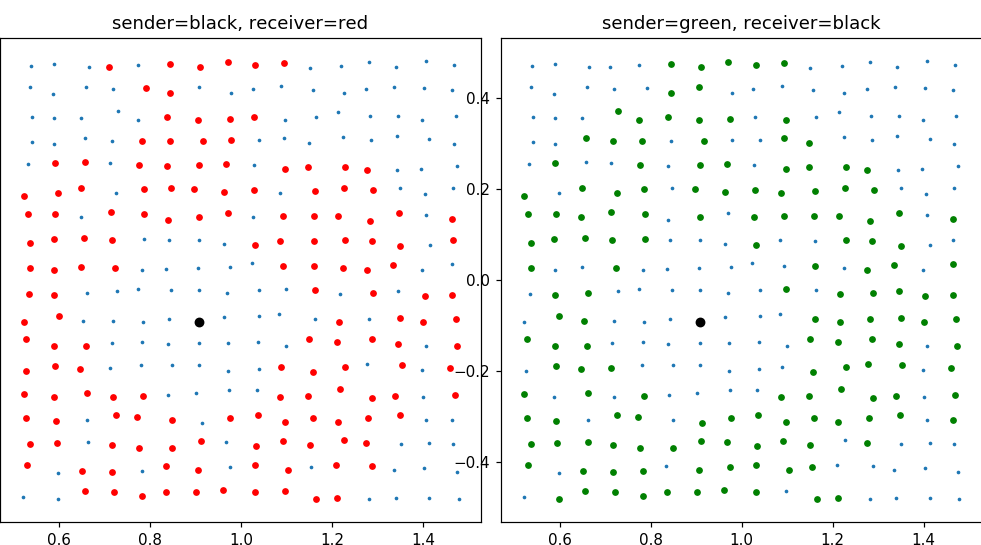

In [4]:
# visualizing the connections 
%matplotlib notebook
# The 'notebook' backend is compatible with FuncAnimation. Another option is 'qt5'.

from matplotlib.animation import FuncAnimation

# flattening net.syns
all_syns = []
for syn_list in net.syns:
    all_syns += syn_list
    
# getting a list with the coordinates of all units
all_coords = [u.coordinates for u in net.units]
n_units = len(all_coords)

fig = plt.figure(figsize=(9,5))
ax1 = fig.add_axes([0.0, 0.01, .49, 0.95], frameon=True, aspect=1)
ax2 = fig.add_axes([0.51, 0.01, .49, 0.95], frameon=True, aspect=1)
ax1.plot(xvals, yvals, 'c.')
ax2.plot(xvals, yvals, 'c.')
ax1.set_title('sender=black, receiver=red')
ax2.set_title('sender=green, receiver=black')

# At each frame we'll visualize the connections arising from a single unit
def update(frame): 
    u = frame%n_units # unit we'll visualize 
    # getting targets of projections from the unit 'u'
    targets = [syn.postID for syn in all_syns if syn.preID == u]
    tar_coords = [ all_coords[t] for t in targets ]
    tar_xcoords = [c[0] for c in tar_coords]
    tar_ycoords = [c[1] for c in tar_coords]
    ax1.clear()
    ax1.scatter(xvals, yvals, s=2)
    ax1.scatter(net.units[u].coordinates[0], net.units[u].coordinates[1], s=30, c='black')
    ax1.scatter(tar_xcoords, tar_ycoords, s=12, c="red")
    ax1.set_title('sender=black, receiver=red')
    # getting units that project to unit 'u'
    sources = [ syn.preID for syn in net.syns[u] ]
    sour_coords = [ all_coords[s] for s in sources ]
    sour_xcoords = [ c[0] for c in sour_coords ]
    sour_ycoords = [ c[1] for c in sour_coords ]
    ax2.clear()
    ax2.scatter(xvals, yvals, s=2)
    ax2.scatter(net.units[u].coordinates[0], net.units[u].coordinates[1], s=30, c='black')
    ax2.scatter(sour_xcoords, sour_ycoords, s=12, c="green")
    ax2.set_title('sender=green, receiver=black')
    
    return ax1,ax2,

animation = FuncAnimation(fig, update, interval=15, blit=True)
plt.show()

### Exercise 1
Alter the simulation loop of part 1 so that the learning rate is decreased 10% in all synapses every 10 input presentations.

To do this it is helpful to look at the code of the oja_synapse class in the synapses.py file. In particular, the __init__
methods has the lines

```
self.lrate = params['lrate'] # learning rate for the synaptic weight
self.alpha = self.lrate * self.net.min_delay # factor that scales the update rule
```
which shows that in addition to the `lrate` attribute, you should also modify the `alpha` attribute.

### Exercise 2
What will happen if you replace the Oja synapses for BCM synapses (synapse_types.bcm)?  
BCM synapses require an extra parameter 'tau_slow' for the postsynaptic unit. The BCM learning rule uses
the temporal average of the squared postsynaptic activity, and this is obtained by low-pass filtering with a
'tau_slow' time constant. Set 'tau_slow' = 4 initially.

Also try Hebbian learning with substractive normalization (synapse_types.hebbsnorm).
An important trait of Hebbian learning with substractive normalization is that the sum of the weights remains fixed.
Does changing the average magnitude of the initial weights change the results?


### Mini-project (for those who would enjoy it)
You could try to extract more than one eigenvector using an algorithm based on:  
Foldiak (1989) "Adaptive network for optimal linear feature extraction"
Proc IEEE/INNS IJCNN 1:401-405

### Exercise 3
Repeat part 3, but this time connect the sigmoidal units so that unit 0 projects to unit 1, unit 1 to unit 2, ..., unit 9 to unit 0.  
Use delays of 0.01, and static synapses with weight 0.5.

In [ ]:
# SOLUTION TO EXERCISE 1

# The cell that performs the simulation can be modified as follows:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# We run the simulation.

# In order for the unit to learn properly, the input patterns need to be presented
# many times. Instead of creating input functions capable of presenting all the
# patterns, we simulate one pattern presentation at a time. After each presentation
# we change the input function used by the source units.

n_pres = 100 # number of times some pattern will be presented
start_time = time.time() # used to time the simulation
times = np.array([]) # used to store the times array from all simulations
activs = np.tile([], (len(net.units),1)) # used to store the activities array from all simulations
run_activs = [] # auxiliary list used to concatenate activities
# <><><><> THE NEXT LINE IS NEW! <><><><><>
curr_lrate = syn_pars['lrate'] # current learning rate. Used to gradually decrease the learning rate

for pres in range(n_pres):
# For each cycle you'll set the input functions and simulate, once with a single pattern,
# once with a mix of patterns, as described above   
    # first, we present a single pattern
    for u in range(n_sources):
        net.units[inp_ids[u]].set_function( make_pat_fun(u) )
        
    sim_dat = net.run(t_pat)  # simulating
    last_t = net.sim_time # simulation time after last pattern presentation
    times = np.append(times, sim_dat[0])
    run_activs.append(sim_dat[1])
    
    # now one pattern turns into the next
    for u in range(n_sources):
        net.units[inp_ids[u]].set_function(make_trans_fun(u, last_t))
    
    sim_dat = net.run(t_trans) # simulating
    times = np.append(times, sim_dat[0])
    run_activs.append(sim_dat[1])
    
    # choose the pattern you'll present next
    cur_pat = next_pat
    next_pat = np.random.choice(4)
    
    if pres%10 == 0:
        print('Finished presentation ' + str(pres))
        # <><><><> THIS IS ALSO NEW! <><><><><>
        curr_lrate = .9 * curr_lrate
        for syn in net.syns[lin_ids[0]]:
            syn.lrate = curr_lrate
            syn.alpha = curr_lrate * net.min_delay
        
activs = np.append(activs, np.concatenate(run_activs, axis=1), axis=1)  
print('Execution time: %s seconds' % (time.time() - start_time)) 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
# SOLUTION TO EXERCISE 3
#--------------- copy-paste ---------------
%cd .. 
from draculab import *
import matplotlib.pyplot as plt

net_params = {
    'min_delay' : 0.005, # minimum delay in all the network's connections (in seconds)
    'min_buff_size' : 10 } # minimum buffer size. How many values are stored per simulation step. 
net = network(net_params)

n_sigs = 10 # how many sigmoidal units to create
sig_params = {
    'type' : unit_types.sigmoidal,  # unit_types is an Enum in draculab.py
    'init_val' : 0.5, # initial value
    'thresh' : .1, # all sigmoidal units will have threshold 1
    'slope' : np.random.uniform(0.5, 2., n_sigs), # the slopes come from a random distribution
    'tau' : 0.02 } # time constant for the dynamics of all sigmoidal units
sig_ids = net.create(n_sigs, sig_params)

n_sources = 10 # how many input units to create
input_params = {
    'type' : unit_types.source,
    'init_val' : 0.5,
    'function' : lambda t: None } 
inp_ids = net.create(n_sources, input_params)

def create_cosine(ang_freq, phase):
    return lambda t: np.cos(ang_freq*(t - phase))

for idx, uid in enumerate(inp_ids):
    net.units[uid].set_function(create_cosine(2.*np.pi, 0.1*idx))
    
conn_spec = {
    'rule' : 'one_to_one',  # all sources connect to all targets
    'delay' : {'distribution': 'uniform', 'low': 0.01, 'high':0.1} }# connection delays will be uniformly distributed
syn_spec = {
    'type': synapse_types.static, # synapse_types is an Enum in draculab.py
    'init_w' : [0.1*n for n in range(n_sigs)] } # the initial weights range from 0. to 0.9
net.connect(inp_ids, sig_ids, conn_spec, syn_spec)
#--------------------------------------

# THE ACTUAL SOLUTION
s2s_conn_spec = {
    'rule' : 'one_to_one',  
    'delay' : 0.01 }
s2s_syn_spec = {
    'type': synapse_types.static, 
    'init_w' : 0.5 }
target_ids = [(i+1)%n_sigs for i in sig_ids] # assuming sig_ids range from 0 to n_sigs...
net.connect(sig_ids, target_ids, s2s_conn_spec, s2s_syn_spec)

#-------- more copy-paste ----------
sim_time = 10. # simulation time
times, unit_acts, _ = net.run(sim_time)

fig = plt.figure(figsize=(20,10))
# Plot the activity of a single sigmoidal unit
plt.subplot(221)
plt.plot(times, unit_acts[sig_ids[2]])
plt.title('one sigmoidal')
# Plot the activity of one input unit
plt.subplot(222)
plt.plot(times, unit_acts[inp_ids[5]])
plt.title('one input')
# Plot the activity of all inputs
inp_acts = [ unit_acts[u] for u in inp_ids ]
plt.subplot(223)
plt.plot(times, np.transpose(inp_acts))
plt.title('all inputs')
# Plot the activity of all sigmoidal units
plt.subplot(224)
sig_acts = [ unit_acts[u] for u in sig_ids ]
plt.plot(times, np.transpose(sig_acts))
plt.title('all sigmoidal units')
plt.show()

In [ ]:
# Using the solution to exercise 1 to visualize the connections made in exercise 3
N = len(net.units) # number of units
weights = np.zeros((N,N)) 
for syn_list in net.syns:
    for syn in syn_list:
        weights[syn.postID, syn.preID] = syn.w

fig_ex1 = plt.figure(figsize=(10,10))
ax = fig_ex1.add_axes([0., 0., 1., 1.], aspect=1)
ax.set_xticks(list(range(N)))
ax.set_yticks(list(range(N)))
ax.imshow(weights)
plt.show()

<IPython.core.display.Javascript object>


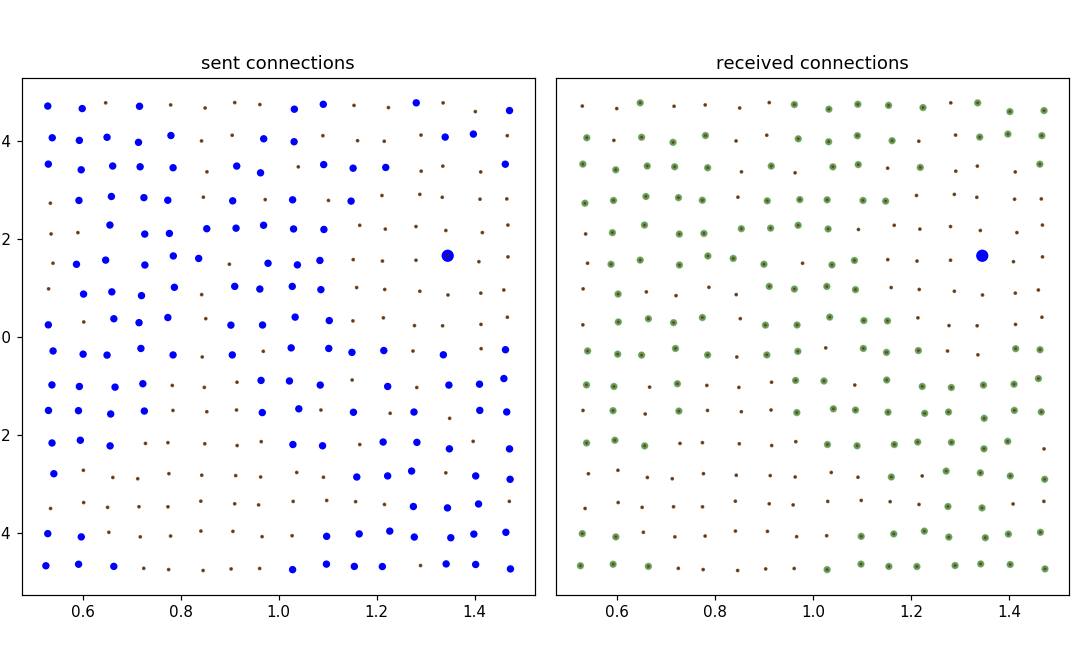

In [7]:
# BONUS SCRIPT!!!
# Faster visualization for connections

# visualizing the connections 
%matplotlib notebook
# The 'notebook' backend is compatible with FuncAnimation
from matplotlib.animation import FuncAnimation
    
# the update function below will use these variables
all_coords = [u.coordinates for u in net.units]
source = [u.ID for u in net.units]
sink = [u.ID for u in net.units]
len_source = len(source)
len_sink = len(sink)
source_0 = source[0]
sink_0 = sink[0]

# flattening net.syns
all_syns = []
for syn_list in [net.syns[i] for i in sink]:
    all_syns.extend([s for s in syn_list if s.preID in source])

# getting lists with the coordinates of all source, sink units
source_coords = [u.coordinates for u in [net.units[i] for i in source]]
sink_coords = [u.coordinates for u in [net.units[i] for i in sink]]
source_x = [c[0] for c in source_coords]
source_y = [c[1] for c in source_coords]
sink_x = [c[0] for c in sink_coords]
sink_y = [c[1] for c in sink_coords]

# id2src[n] maps the unit with network id 'n' to its index in the 'source' list
id2src = np.array([1e8 for _ in range(len(net.units))], dtype=int) # 1e8 if not in source
for src_idx, net_idx in enumerate(source):
    id2src[net_idx] = src_idx
# id2snk[n] maps the unit with network id 'n' to its index in the 'sink' list
id2snk = np.array([1e8 for _ in range(len(net.units))], dtype=int) # 1e8 if not in sink
for snk_idx, net_idx in enumerate(sink):
    id2snk[net_idx] = snk_idx

# setting colors
std_src = [0., 0.5, 0., 0.5]
std_snk = [0.5, 0., 0., 0.5]
big_src = [0., 0., 1., 1.]
big_snk = [0., 0., 1., 1.]

# constructing figure, axes, path collections
conn_fig = plt.figure(figsize=(10,6))
ax1 = conn_fig.add_axes([0.02, 0.01, .47, 0.95], frameon=True, aspect=1)
ax2 = conn_fig.add_axes([0.51, 0.01, .47, 0.95], frameon=True, aspect=1)
src_col1 = ax1.scatter(source_x, source_y, s=2, c=std_src)
snk_col1 = ax1.scatter(sink_x, sink_y, s=2, c=std_snk)
src_col2 = ax2.scatter(source_x, source_y, s=2, c=std_src)
snk_col2 = ax2.scatter(sink_x, sink_y, s=2, c=std_snk)
ax1.set_title('sent connections')
ax2.set_title('received connections')
ax2.set_yticks([])


# At each frame we'll visualize the connections arising from a single unit
def update(frame): 
    sou_u = frame%len_source # source unit whose receivers we'll visualize
    snk_u = frame%len_sink # sink unit whose senders we'll visualize

    # PLOTTING THE RECEIVERS OF sou_u ON THE LEFT AXIS
    source_sizes = np.tile(2, len_source)
    sink_sizes = np.tile(2, len_sink)
    source_colors = np.tile(std_src,(len_source,1))
    sink_colors = np.tile(std_snk, (len_sink,1))
    source_sizes[sou_u] = 50
    source_colors[sou_u] = big_src
    # getting targets of projections from the unit 'sou_u'
    targets = id2snk[ [syn.postID for syn in all_syns if id2src[syn.preID] == sou_u ] ]
    # setting the colors and sizes
    sink_colors[targets] = big_snk
    sink_sizes[targets] = 15
    src_col1.set_sizes(source_sizes)
    #ax1.get_children()[0].set_sizes(source_sizes)   # sizes for the source units
    snk_col1.set_sizes(sink_sizes)
    src_col1.set_color(source_colors)
    snk_col1.set_color(sink_colors)

    # PLOTTING THE SENDERS TO snk_u ON THE RIGHT AXIS
    source_sizes = np.tile(2, len_source)
    sink_sizes = np.tile(2, len_sink)
    source_colors = np.tile(std_src, (len_source,1))
    sink_colors = np.tile(std_snk, (len_sink,1))
    sink_sizes[snk_u] = 50
    sink_colors[snk_u] = big_snk
    # getting senders of projections to the unit 'snk_u
    senders = id2src[ [syn.preID for syn in all_syns if id2snk[syn.postID] == snk_u] ]
    # setting the colors and sizes
    source_colors[senders] = std_src
    source_sizes[senders] = 15
    src_col2.set_sizes(source_sizes)
    snk_col2.set_sizes(sink_sizes)
    src_col2.set_color(source_colors)
    snk_col2.set_color(sink_colors)

    return ax1, ax2,

animation = FuncAnimation(conn_fig, update, interval=30, blit=True)
plt.show()